In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 18.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.2 MB/s eta 0:00:0000:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [23]:
from clip_embeddings_generator import ClipEmbeddingsGenerator, draw_images
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection
import os
import torch
import numpy as np

In [3]:
connections.connect(alias="avatars", host="milvus-standalone", port="19530")

fields = [
    FieldSchema(
        name="embedding", dtype=DataType.FLOAT_VECTOR, dim=512
    ),
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True),
]
schema = CollectionSchema(fields, description="Avatar collection")

collection = Collection(name="avatar_collection", schema=schema, using="avatars")

In [4]:
embedder = ClipEmbeddingsGenerator()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
image_dir = "images/"
image_paths = [os.path.join(image_dir, img)
               for img in os.listdir(image_dir) if img.endswith(".png")]

In [6]:
# Procesamos las imágenes en batches para evitar un OutOfMemoryError
# (Nuestra gpu es de 4GB)
batch_size = 1
image_embeddings = []
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i + batch_size]
    batch_embeddings = embedder.embedd_images(batch_paths)
    image_embeddings.extend(batch_embeddings)

image_embeddings = np.array(image_embeddings)

In [8]:
allocated = torch.cuda.memory_allocated() / (1024 ** 2)
reserved = torch.cuda.memory_reserved() / (1024 ** 2)

print(f"Allocated Memory: {allocated:.2f} MiB")
print(f"Reserved Memory: {reserved:.2f} MiB")

Allocated Memory: 585.20 MiB
Reserved Memory: 670.00 MiB


In [12]:
image_embeddings.shape

(229, 512)

In [14]:
ids = list(range(len(image_embeddings)))

entities = [image_embeddings.tolist(), ids]

collection.insert(entities)

(insert count: 229, delete count: 0, upsert count: 0, timestamp: 449850916253204483, success count: 229, err count: 0, cost: 0)

In [15]:
index_params = {
    "metric_type": "L2",
    "index_type": "IVF_FLAT",
    "params": {"nlist": 128}
}
collection.create_index(field_name="embedding", index_params=index_params)

Status(code=0, message=)

In [19]:
def search_by_text(text: str, top_k: int = 5):
    text_embedding = embedder.embedd_texts([text])[0]
    
    search_params = {
        "metric_type": "L2",
        "params": {"nprobe": 10}
    }
    
    results = collection.search(
        data=[text_embedding],
        anns_field="embedding",
        param=search_params,
        limit=top_k,
        expr=None
    )
    
    return results

In [21]:
text_query = "A cat"
collection.load()
search_results = search_by_text(text_query)

for result in search_results[0]:
    print(f"ID: {result.id}, Distance: {result.distance}")

ID: 207, Distance: 166.6036834716797
ID: 138, Distance: 169.62704467773438
ID: 96, Distance: 169.989013671875
ID: 186, Distance: 170.5663299560547
ID: 225, Distance: 170.80377197265625


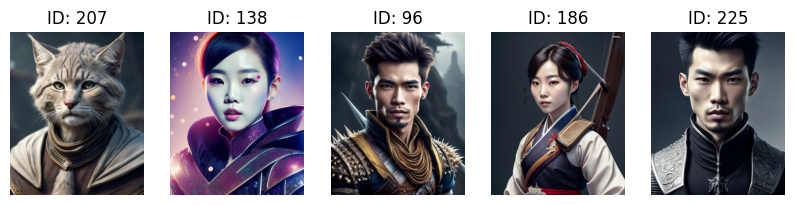

In [25]:
result_ids = [result.id for result in search_results[0]]
result_paths = [image_paths[id] for id in result_ids]
result_titles = [f"ID: {id}" for id, result in zip(result_ids, search_results[0])]

draw_images(result_paths, result_titles)